In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy

import jointpmf as jp  # might generate some warnings (BLAS), you can ignore

c:\Users\rquax1\Repositories\jointpmf_package\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# first a very simple example code of how to find an SRV (in this case always the XOR or NOT-XOR)
pdf = jp.JointProbabilityMatrix(2, 2, 'uniform')
pdf.append_synergistic_variables(1, num_repeats=1)
print(pdf.conditional_probability_distributions([0,1], [2]))  # output format: (X1, X2) --> [Pr(SRV(X1, X2)=0), Pr(SRV(X1, X2)=1)]

{(0, 0): [1.0, 0.0], (0, 1): [0.0, 1.0], (1, 0): [0.0, 1.0], (1, 1): [1.0, 0.0]}


# Does caching make computations faster?

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
times_append_syn = dict()  # from cache_upto (int) to float (seconds)
times_compute_mi = dict()  # likewise
times_precache = dict()  # likewise
times_compute_H_X1 = dict()  # likewise
times_compute_H_X2 = dict()  # likewise
times_compute_H_Y = dict()  # likewise
times_compute_rev_mi = dict()

numvalues = 2
num_init_vars = 5

ntrials = 20

df_cache_timings = pd.DataFrame(columns=['upto', 'times_append_syn', 'times_precache', 'times_compute_H_X1', 
                                         'times_compute_H_X2', 'times_compute_H_Y', 'times_compute_mi', 
                                         'times_compute_rev_mi'])

for _ in range(ntrials):
    bn_line = jp.BayesianNetwork()
    bn_line.infer_random_bn_on_dag(num_init_vars, numvalues, method_pdf='uniform', method_cond_pdf=0.2, max_opt_evals=500)

    for upto in range(5):
        bn = copy.deepcopy(bn_line)  # copy the exact same 'line' BN in every loop iteration to make the timings comparable
        bn._use_cache_upto = upto  # set caching threshold

        times_precache[upto] = time.time()
        bn.precompute_marginal_cache()
        times_precache[upto] = time.time() - times_precache[upto]

        srv_inputs = list(range(len(bn) - 2, len(bn)))

        times_append_syn[upto] = time.time()
        bn.append_synergistic_variable(srv_inputs, max_evals=200)
        times_append_syn[upto] = time.time() - times_append_syn[upto]

        times_compute_H_X1[upto] = time.time()
        H_X1 = bn.entropy([srv_inputs[0]])
        times_compute_H_X1[upto] = time.time() - times_compute_H_X1[upto]

        times_compute_H_X2[upto] = time.time()
        H_X2 = bn.entropy([srv_inputs[1]])
        times_compute_H_X2[upto] = time.time() - times_compute_H_X2[upto]

        times_compute_H_Y[upto] = time.time()
        H_Y = bn.entropy([len(bn) - 1])
        times_compute_H_Y[upto] = time.time() - times_compute_H_Y[upto]

        times_compute_mi[upto] = time.time()
        srv_mi = bn.mutual_information(srv_inputs, [len(bn) - 1])
        times_compute_mi[upto] = time.time() - times_compute_mi[upto]

        times_compute_rev_mi[upto] = time.time()
        srv_rev_mi = bn.mutual_information([len(bn) - 1], srv_inputs)
        times_compute_rev_mi[upto] = time.time() - times_compute_rev_mi[upto]

        row = {'upto': upto, 
            'times_append_syn': times_append_syn[upto], 
            'times_precache': times_precache[upto], 
            'times_compute_H_X1': times_compute_H_X1[upto],
            'times_compute_H_X2': times_compute_H_X2[upto], 
            'times_compute_H_Y': times_compute_H_Y[upto], 
            'times_compute_mi': times_compute_mi[upto],
            'times_compute_rev_mi': times_compute_rev_mi[upto]}
        df_cache_timings.loc[len(df_cache_timings)] = row

        if ntrials == 1:
            print(f'Finished {upto=}, took (sum):')
            print(f'\t{times_precache[upto]=}\n\t{times_append_syn[upto]=}\n\t{times_compute_mi[upto]=}\n\t{times_compute_H_X1[upto]=}\n\t{times_compute_H_X2[upto]=}\n\t{times_compute_H_Y[upto]=}\n\t{times_compute_rev_mi[upto]=}.\n\tNumber of cached PMF: {len(bn._marginal_pmf_cache)}')

print('---')

df_cache_timings.head()  # show a summary

---


upto  times_append_syn  times_precache  times_compute_H_X1  \
0      0        288.672747        0.000000            0.008026   
1      1        238.556706        0.022587            0.007994   
2      2        159.763592        0.137635            0.016011   
3      3        169.536117        0.257841            0.007991   
4      4        220.078051        0.452882            0.032198   
5      0         86.769936        0.000000            0.005052   
6      1         79.915080        0.032557            0.000000   
7      2         66.145638        0.112592            0.007979   
8      3         47.273798        0.296426            0.006526   
9      4         70.543746        0.690546            0.015717   
10     0        219.858361        0.000000            0.009996   
11     1         59.346481        0.039045            0.005493   
12     2         50.662879        0.166764            0.005085   
13     3         47.525646        0.298353            0.012000   
14     4         49.301952        0.247916            0.004001   
15     0         57.272719        0.000000            0.005025   
16     1         38.042212        0.014987            0.002012   
17     2         24.064091        0.037458            0.004087   
18     3         23.751081        0.113168            0.001000   
19     4         24.284415        0.128018            0.002000   
20     0         35.347799        0.000000            0.002002   
21     1         35.724532        0.007024            0.003996   
22     2         63.678455        0.073288            0.001998   
23     3         37.795549        0.167063            0.002069   
24     4         30.519923        0.151621            0.001000   

    times_compute_H_X2  times_compute_H_Y  times_compute_mi  \
0             0.008014           0.120666          0.927810   
1             0.016112           0.119891          0.176164   
2             0.000000           0.136620          0.152238   
3             0.008013           0.200217          0.308186   
4             0.020994           0.390100          0.850674   
5             0.008054           0.049440          0.261144   
6             0.008029           0.023981          0.039984   
7             0.000000           0.032700          0.048800   
8             0.008066           0.023542          0.068991   
9             0.005525           0.127239          0.051142   
10            0.020997           0.051000          0.490472   
11            0.019806           0.076498          0.089630   
12            0.021997           0.053918          0.056115   
13            0.012000           0.035083          0.035902   
14            0.017023           0.040437          0.076347   
15            0.003996           0.027276          0.196129   
16            0.005086           0.022251          0.025197   
17            0.007012           0.024021          0.033878   
18            0.002999           0.020026          0.023916   
19            0.008095           0.025904          0.035000   
20            0.004001           0.019992          0.134098   
21            0.006004           0.045242          0.057000   
22            0.007010           0.053270          0.083907   
23            0.001989           0.019896          0.030006   
24            0.002990           0.029997          0.028907   

    times_compute_rev_mi  
0               0.348353  
1               0.274422  
2               0.128942  
3               0.208750  
4               0.542169  
5               0.105111  
6               0.088027  
7               0.040041  
8               0.053190  
9               0.073763  
10              0.145001  
11              0.145796  
12              0.062457  
13              0.047858  
14              0.077496  
15              0.063103  
16              0.052322  
17              0.030056  
18              0.029992  
19              0.023000  
20              0.047899  
21              0.103667  
22              0.073426  


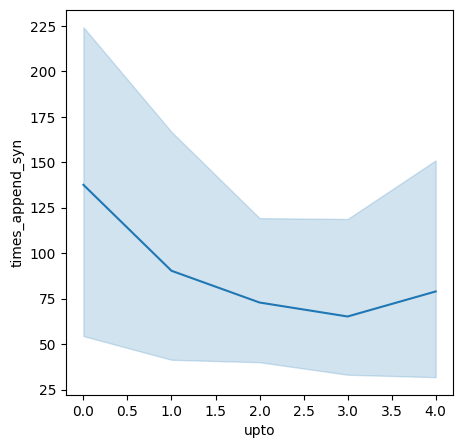

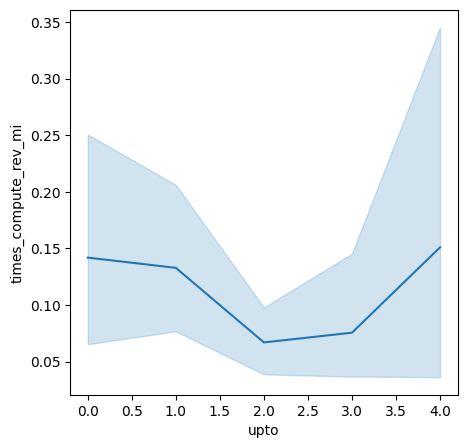

In [4]:
plt.figure(figsize=(5, 5))
sns.lineplot(df_cache_timings, x='upto', y='times_append_syn')
plt.show()
plt.figure(figsize=(5, 5))
sns.lineplot(df_cache_timings, x='upto', y='times_compute_rev_mi')
plt.show()

## Initial guess of XOR: faster for binary?

In [3]:
%%timeit -n10
# is it faster to start from an XOR guess? (note: run first the above a few times so that we don't get cache effects here)
pdf = jp.JointProbabilityMatrix(2, 2, 'uniform')
pdf.append_synergistic_variables(1, num_repeats=10, initial_guess_summed_modulo=False)

1.18 s ± 502 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
%%timeit -n10
# is it faster to start from an XOR guess? 
pdf = jp.JointProbabilityMatrix(2, 2, 'uniform')
pdf.append_synergistic_variables(1, num_repeats=10, initial_guess_summed_modulo=True)

354 ms ± 46.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Initial guess of parity: faster for non-binary?

In [5]:
numvars = 2
numvals = 3
numsrvs = 1

In [6]:
# first run this once or twice to prevent cache effects in the below cells, where we compare running time
pdf = jp.JointProbabilityMatrix(numvars, numvals, 'uniform')
pdf.append_synergistic_variables(numsrvs, num_repeats=10, initial_guess_summed_modulo=False)

In [7]:
%%timeit -n5
# warning: for numvals >= 5 this takes forever
# first run without an XOR initial guess (note: run first the above a few times so that we don't get cache effects here)
pdf = jp.JointProbabilityMatrix(numvars, numvals, 'uniform')
try:
    pdf.append_synergistic_variables(numsrvs, num_repeats=5, initial_guess_summed_modulo=False)
except UserWarning as e:
    print('error: ' + str(e))

KeyboardInterrupt: 

In [8]:
%%timeit -n5
# is it faster to start from an XOR guess?
pdf = jp.JointProbabilityMatrix(numvars, numvals, 'uniform')
pdf.append_synergistic_variables(numsrvs, num_repeats=5, initial_guess_summed_modulo=True)

431 ms ± 99.5 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## Initial guess of parity: also faster for >2 input variables?

In [9]:
numvars = 3
numvals = 2
numsrvs = 1

In [10]:
# first run this once or twice to prevent cache effects in the below cells, where we compare running time
pdf = jp.JointProbabilityMatrix(numvars, numvals, 'uniform')
pdf.append_synergistic_variables(numsrvs, num_repeats=5, initial_guess_summed_modulo=False)

In [11]:
%%timeit -n5
# first run without an XOR initial guess (note: run first the above a few times so that we don't get cache effects here)
pdf = jp.JointProbabilityMatrix(numvars, numvals, 'uniform')
try:
    pdf.append_synergistic_variables(numsrvs, num_repeats=5, initial_guess_summed_modulo=False)
except UserWarning as e:
    print('error: ' + str(e))

2.91 s ± 926 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [12]:
%%timeit -n5
# is it faster to start from an XOR guess?
pdf = jp.JointProbabilityMatrix(numvars, numvals, 'uniform')
try:
    pdf.append_synergistic_variables(numsrvs, num_repeats=5, initial_guess_summed_modulo=True)
except UserWarning as e:
    print('error: ' + str(e))

535 ms ± 216 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## Initial guess of parity: also faster when adding >2 SRV variables?

In [13]:
numvars = 3
numvals = 2
numsrvs = 2

In [14]:
# first run this once or twice to prevent cache effects in the below cells, where we compare running time
pdf = jp.JointProbabilityMatrix(numvars, numvals, 'uniform')
pdf.append_synergistic_variables(numsrvs, num_repeats=5, initial_guess_summed_modulo=False)

KeyboardInterrupt: 

In [15]:
%%timeit -n5
# first run without an XOR initial guess (note: run first the above a few times so that we don't get cache effects here)
pdf = jp.JointProbabilityMatrix(numvars, numvals, 'uniform')
try:
    pdf.append_synergistic_variables(numsrvs, num_repeats=5, initial_guess_summed_modulo=False)
except UserWarning as e:
    print('error: ' + str(e))

The slowest run took 14.27 times longer than the fastest. This could mean that an intermediate result is being cached.
6min 47s ± 7min 15s per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [16]:
%%timeit -n5
# is it faster to start from an XOR guess?
pdf = jp.JointProbabilityMatrix(numvars, numvals, 'uniform')
try:
    pdf.append_synergistic_variables(numsrvs, num_repeats=5, initial_guess_summed_modulo=True)
except UserWarning as e:
    print('error: ' + str(e))

# Do SRVs tend to be modulo-sum functions of their inputs?

In [ ]:
from pathos.pools import ParallelPool
from pathos.helpers import cpu_count
import copy
import time

In [ ]:
print('This computer has %i cores.' % cpu_count())

In [ ]:
numvars = 2
numvals = 3
numsrvs = 1
distribution = 'dirichlet'
num_repeats = 5

num_pdfs = 10
ncores = cpu_count() - 1  # advisable to leave at least one core for browsing, email, etc.

In [ ]:
global_list_of_pdfs = []

In [ ]:
# each item is a tuple: (pdf, pdf_with_srv1, pdf_with_srv2)
list_of_pdfs = [[] for _ in range(num_pdfs)]

# worker function for use in (pathos) multiprocessing
def compute_pdfs_with_srv(ix):
    pdf = jp.JointProbabilityMatrix(numvars, numvals, 'uniform')
    original_pdf = copy.deepcopy(pdf)
    list_of_pdfs[ix].append(pdf)
    
    try:
        pdf.append_synergistic_variables(numsrvs, num_repeats=5, initial_guess_summed_modulo=False)
    except UserWarning as e:
        pdf = None
    
    pdf2 = copy.deepcopy(original_pdf)  # reset

    # also try to find SRVs using an initial guess of modulo-sum to compare statistics with finding them without such initial guess
    try:
        pdf2.append_synergistic_variables(numsrvs, num_repeats=5, initial_guess_summed_modulo=True)
    except UserWarning as e:
        pdf2 = None
    
    return (original_pdf, pdf, pdf2)

pool = ParallelPool(nodes=ncores)

start_time = time.time()
list_of_pdfs = pool.map(compute_pdfs_with_srv, range(num_pdfs))
end_time = time.time()

# check for every item in list_of_pdfs whether it is 'complete' (none of the pdf's are 'None', where None indicates not being able to find an SRV)
list_of_completeness = [not (list_of_pdfs[ix][1] is None or list_of_pdfs[ix][2] is None) for ix in range(len(list_of_pdfs))]

print('Computation took %f seconds. Out of %i pdfs, %i were successful in finding an SRV in all cases.' % (end_time - start_time, len(list_of_pdfs), sum(list_of_completeness)))

In [ ]:
global_list_of_pdfs += list_of_pdfs  # this way the above cell can be run multiple times together with this cell, to get bigger result lists

In [ ]:
# print conditional pdfs of SRVs
for ix in range(len(global_list_of_pdfs)):
    if ix < 10:  # keep printing pretty (...)
        print('-----pdf #%i------' % ix)
    else:
        print('-----pdf #%i-----' % ix)

    original_pdf, pdf1, pdf2 = global_list_of_pdfs[ix]  # shorthand

    if pdf1 is None:
        print('None')
    else:
        print(str(pdf1.conditional_probability_distributions(list(range(numvars)), list(range(numvars, numvars+numsrvs)))))
    
    if pdf2 is None:
        print('None')
    else:
        print(str(pdf2.conditional_probability_distributions(list(range(numvars)), list(range(numvars, numvars+numsrvs)))))

print('------------------')

In [ ]:
max_marginal_entropy = np.log2(numvals)

# print entropy and conditional entropy, as a statistic of how close it is to an XOR-like or module-sum function
for ix in range(len(global_list_of_pdfs)):
    if ix < 10:  # keep printing pretty (...)
        print('-----pdf #%i------' % ix)
    else:
        print('-----pdf #%i-----' % ix)

    original_pdf, pdf1, pdf2 = global_list_of_pdfs[ix]  # shorthand

    H_S1 = pdf1.entropy(list(range(numvars, numvars+numsrvs)))  # marginal entropy of SRVs
    H_S2 = pdf2.entropy(list(range(numvars, numvars+numsrvs)))

    H_S_X1 = pdf1.conditional_entropy(variables=list(range(numvars, numvars+numsrvs)), given_variables=list(range(numvars)))  # conditional entropy of SRVs
    H_S_X2 = pdf2.conditional_entropy(variables=list(range(numvars, numvars+numsrvs)), given_variables=list(range(numvars)))

    print('(H_S1, H_S_X1, H_S2, H_S_X2, max_marginal_entropy) = ' + str((H_S1, H_S_X1, H_S2, H_S_X2, max_marginal_entropy)))